In [198]:
import findspark
findspark.init()

In [199]:
from pyspark.sql import SparkSession, DataFrame
from collections import Counter
from pyspark.sql.functions import col, when, year, current_date, datediff, to_date, year, current_date
import datetime

spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [200]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("mode", "PERMISSIVE") \
    .csv("/dataset/nyc-jobs.csv")

# using this as I noticed \r in the last column (Process Date)
df = df.toDF(*[c.replace("\r", "").strip() for c in df.columns])

df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

### Step 1: Utility & Normalizing Functions

In [201]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, when, year, current_date, datediff, count, when

# 1. Clean salary columns
def normalize_salary(df: DataFrame) -> DataFrame:
    """
    Normalize salary to annual salary.
    Assumes 2080 working hours/year for hourly postings.
    """
    return df.withColumn(
        "annual_salary",
        when(col("Salary Frequency")=="Hourly", col("Salary Range To")*2080)
        .otherwise(col("Salary Range To"))
    )

# 2. Create average salary column
def add_avg_salary(df: DataFrame) -> DataFrame:
    return df.withColumn("avg_salary", (col("Salary Range From")+col("Salary Range To"))/2)

# 3. Flag degree requirement
def add_degree_flag(df: DataFrame) -> DataFrame:
    return df.withColumn(
        "requires_degree",
        when(col("Minimum Qual Requirements").rlike("Master|PhD"), 1).otherwise(0)
    )

# 4. Add posting recency
def add_posting_recency(df: DataFrame) -> DataFrame:
    return df.withColumn("days_since_posting", datediff(current_date(), col("Posting Date")))

### Step 2: KPI Functions

In [202]:
# KPI 1: Top 10 job categories
def top_job_categories(df: DataFrame) -> DataFrame:
    return df.groupBy("Job Category").count().orderBy(col("count").desc()).limit(10)

# KPI 2: Salary distribution per category
def salary_distribution(df: DataFrame) -> DataFrame:
    return df.groupBy("Job Category").agg({"avg_salary":"avg"})

# KPI 3: Correlation between degree and salary
def degree_salary_correlation(df: DataFrame) -> float:
    return df.stat.corr("requires_degree", "annual_salary")

# KPI 4: Highest salary per agency
def highest_salary_per_agency(df: DataFrame) -> DataFrame:
    return df.groupBy("Agency").agg({"annual_salary":"max"})

# KPI 5: Average salary per agency (last 2 years)
def avg_salary_last2yrs(df: DataFrame) -> DataFrame:
    
    ## converting posting date column to date type first
    df = df.withColumn("Posting Date", to_date(col("Posting Date"), "MM/dd/yyyy"))
    
    ## applying logic to get average salary per agency for last 2 years
    df_recent = df.withColumn("year", year(col("Posting Date"))).filter(col("year") >= datetime.date.today().year - 1)
    return df_recent.groupBy("Agency").agg({"avg_salary":"avg"})

### Step 3: Visualization functions

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_categories(df: DataFrame):
    top10 = df.groupBy("Job Category").count().orderBy("count", ascending=False).limit(10)
    pdf = top10.toPandas()
    sns.barplot(x="Job Category", y="count", data=pdf)
    plt.xticks(rotation=90)
    plt.show()

def plot_salary_distribution(df: DataFrame):
    pdf = df.toPandas()
    sns.boxplot(x="Job Category", y="avg_salary", data=pdf)
    plt.xticks(rotation=90, ha="right")
    plt.show()


### Step 4: Feature Removal

In [204]:
# As we have added average salary and annual salary in the dataframe, we can now remove Salary From, Salary To and Salary Frequency
# Removing redundant columns like Job ID (if already unique and not needed downstream) and Posting ID which has duplicates
def drop_redundant_features(df: DataFrame) -> DataFrame:
    cols_to_drop = ["Salary From", "Salary To", "Salary Frequency", "Job ID", "Posting ID", "Work Location 1"]
    df = df.drop(*cols_to_drop)
    return df

# Drop sparse columns like those columns with more than 70 or 80 percent null values
def drop_sparse_columns(df: DataFrame) -> DataFrame:
    threshold = 0.7
    total_rows = df.count()
    null_counts = df.select([
        (count(when(col(c).isNull(), c)) / total_rows).alias(c)
        for c in df.columns
    ]).collect()[0].asDict()
    
#     print(null_counts)
    sparse_columns = [
        col_name for col_name, null_ratio in null_counts.items()
        if null_ratio > threshold
    ]

    print("sparse columns: ", sparse_columns)
    df = df.drop(*sparse_columns)
    return df    

### Step 5: Test Cases

In [205]:
def test_salary_normalization(df: DataFrame):
    assert df.filter(df["Salary Frequency"]=="Hourly").select("annual_salary").first()[0] > 0

def test_top_categories(df: DataFrame):
    top10 = top_job_categories(df).count()

### Step 6: Putting It All Together

In [206]:
def process_data(df: DataFrame) -> DataFrame:
    df = normalize_salary(df)
    df = add_avg_salary(df)
    df = add_degree_flag(df)
    df = add_posting_recency(df)
    df = drop_redundant_features(df)
    df = drop_sparse_columns(df)
    return df

### executing the pipeline using above functions

In [207]:
df = process_data(df)

top_job_categories(df).show()
salary_distribution(df).show()
print("Correlation:", degree_salary_correlation(df))
highest_salary_per_agency(df).show()
avg_salary_last2yrs(df).show()

sparse columns:  ['Recruitment Contact', 'Post Until']
+--------------------+-----+
|        Job Category|count|
+--------------------+-----+
|Engineering, Arch...|  504|
|Technology, Data ...|  313|
|       Legal Affairs|  226|
|Public Safety, In...|  182|
|Building Operatio...|  181|
|Finance, Accounti...|  169|
|Administration & ...|  134|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  124|
+--------------------+-----+

+--------------------+------------------+
|        Job Category|   avg(avg_salary)|
+--------------------+------------------+
|Administration & ...|           95000.0|
|Health Policy, Re...|          128694.5|
|Administration & ...|           69040.5|
|Information Techn...|           76941.5|
|Finance, Accounti...|           63024.5|
|Engineering, Arch...|          63349.78|
|Legal Affairs Pol...| 88898.66666666667|
|Administration & ...|           53075.5|
|Constituent Servi...|57877.577803875974|
|Building Operatio...| 37597.39734

### Visualizations

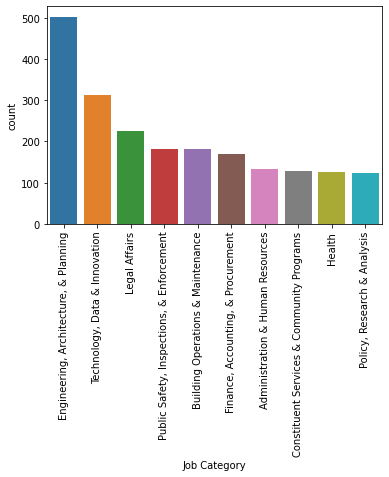

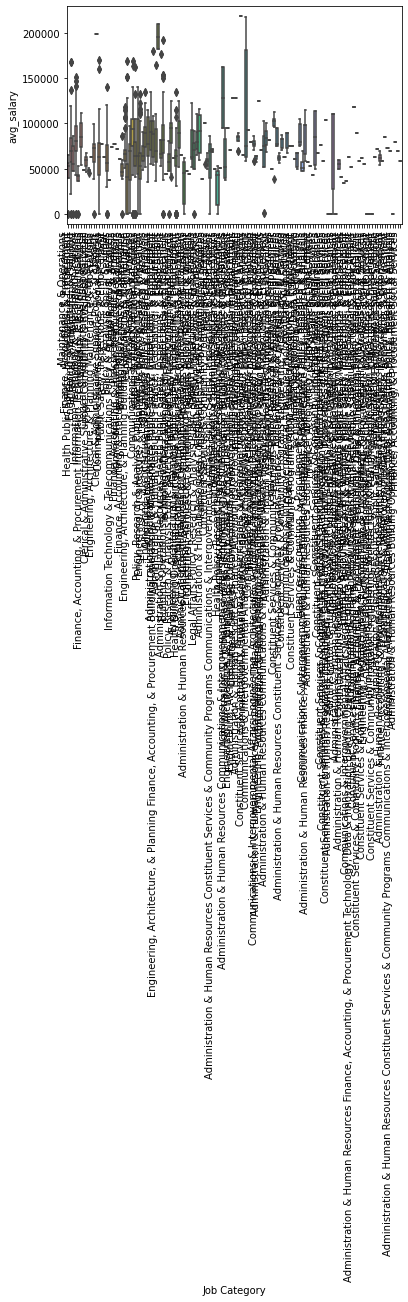

In [208]:
plot_top_categories(df)
plot_salary_distribution(df)

In [209]:
### Sanitizing Column names to write as parquet file

In [210]:
import re

def sanitize_columns(df):
    cleaned_columns = [
        re.sub(r'[ ,;{}()\n\t=]+', '_', col_name.strip())
        for col_name in df.columns
    ]
    return df.toDF(*cleaned_columns)

df = sanitize_columns(df)

### Saving Target File

In [231]:
print(df.columns)
print("Row count:", df.count())

df.write \
    .mode("overwrite") \
    .parquet("/dataset/output/processed_data")

['Agency', 'Posting_Type', '#_Of_Positions', 'Business_Title', 'Civil_Service_Title', 'Title_Code_No', 'Level', 'Job_Category', 'Full-Time/Part-Time_indicator', 'Salary_Range_From', 'Salary_Range_To', 'Work_Location', 'Division/Work_Unit', 'Job_Description', 'Minimum_Qual_Requirements', 'Preferred_Skills', 'Additional_Information', 'To_Apply', 'Hours/Shift', 'Residency_Requirement', 'Posting_Date', 'Posting_Updated', 'Process_Date', 'annual_salary', 'avg_salary', 'requires_degree', 'days_since_posting']
Row count: 2946
